In [1]:
import numpy as np
import pandas as pd

In [2]:
from data_files import get_train_validation_test_files

In [3]:
import os
train_test_folder = '/data/km3net/Xy_multi_data_files/train_test_files/log_energies_stratified/'
#train_test_folder = 'Xy_multi_data_files_logE/train_test_files/energies/'
fnames_train, fnames_val, fnames_test, index_split_files = get_train_validation_test_files(train_test_folder)

In [4]:
from data_loaders import metadata_generator, get_n_iterations, data_generator

Using TensorFlow backend.


In [5]:
predict_steps, tot_test_events = get_n_iterations(fnames_test, batch_size=64)

In [6]:
print(predict_steps, tot_test_events)

810 51818


In [7]:
from data_files import get_multi_data_files

In [8]:
# IRON-HIDE 
multi_files_paths = get_multi_data_files('/data/km3net/Xy_multi_data_files/')
# UNISA: multi_files_paths = get_multi_data_files('aafiles/Jpp_v6_aa_files/Xy_multi_data_files/')

In [9]:
from keras import backend as K

def get_TZ_XY(X):
    TZ = np.sum(X, axis=(2, 3))
    XY = np.sum(X, axis = (1,4))
    if K.image_data_format() == "channels_first":
        TZ = TZ[:, np.newaxis, ...]
        XY = XY[:, np.newaxis, ...]
    else:
        TZ = TZ[..., np.newaxis]
        XY = XY[..., np.newaxis]
    return [TZ, XY]

test_data_generator = data_generator(fnames_test, batch_size=64, fdata=get_TZ_XY, ftarget=lambda y: y)
metadata_keylist = ['E', 'posx', 'posy', 'posz', 'dirx', 'diry', 'dirz']
metadata_gen = metadata_generator(index_split_files, multi_files_paths, metadata_keylist)

In [10]:
import keras

In [11]:
from network_models import inference_step

In [12]:
from network_models import TZXY_regression_logE_relu_tanh
model = TZXY_regression_logE_relu_tanh()
#model = keras.models.load_model('./model/net_logE_shallow_relu_tanh_linear_64_100_regression_logE.hdf5')
model.load_weights('./model_no_git/net_logE_shallow_relu_tanh_linear_net_weights_training.hdf5')

In [13]:
metadata, y_true, y_pred = inference_step(model, test_data_generator, predict_steps, 
                                          metadata_gen, categorical=False)

100%|██████████| 810/810 [03:05<00:00,  4.36it/s]


In [22]:
metadata["evt_index"]

0         442
1        1857
2         717
3        1620
4         814
5          59
6        2430
7        1682
8        1262
9        1570
10        889
11       1743
12       1105
13       1748
14       1424
15        149
16       1745
17        247
18       1085
19       1217
20       2089
21       1934
22        343
23       2187
24       2404
25       1087
26        728
27       1343
28         54
29       1615
         ... 
51788    2534
51789     311
51790    1747
51791    1987
51792    1171
51793    2268
51794     165
51795    1732
51796     525
51797     102
51798    1342
51799    2028
51800    2012
51801     556
51802    1746
51803     814
51804    1974
51805    1683
51806    1484
51807    1281
51808    1796
51809    1487
51810    1011
51811     570
51812     594
51813    1940
51814    1623
51815    1673
51816    2264
51817     994
Name: evt_index, Length: 51818, dtype: uint64

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
mean_squared_error(y_true, y_pred)

0.22250349242270745

In [16]:
r2_score(y_true, y_pred)

0.84326095148332403

In [17]:
np.savetxt("energy_true.txt", y_true)
np.savetxt("energy_pred.txt", y_pred)

### Plot NuMUCC + NuE Energy Regression

In [18]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

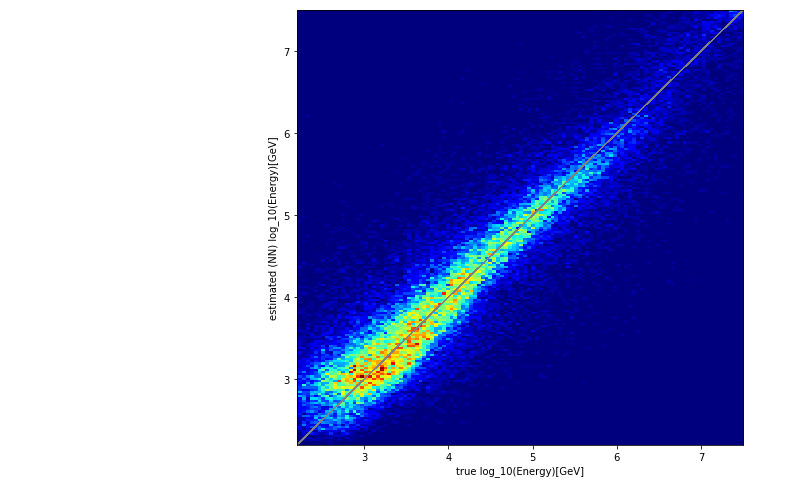

In [55]:
plt.figure(figsize=(8, 8))
plt.plot(y_true, y_true, color='grey', linestyle='-.', lw=0.5)
# plt.plot(y_true, y_pred, color='k', linestyle='solid')
#plt.scatter(y_true, y_pred, marker='o', color="blue", edgecolor='w')
plt.hist2d(y_true, y_pred, bins=200, cmap='jet')
plt.xlabel('true log_10(Energy)[GeV]')
plt.ylabel('estimated (NN) log_10(Energy)[GeV]')
plt.xlim([2.2,7.5])
plt.ylim([2.2,7.5])
plt.title('')
plt.show()

Energy resolution plot

In [21]:
10**y_true

array([  1610.24 ,    966.383,  37401.6  , ...,    126.978,   8176.94 ,
         8237.04 ])

In [22]:
10**y_pred

array([  4327.01123047,   1471.10778809,  16965.53320312, ...,
          230.66644287,  42574.72265625,   1326.71520996], dtype=float32)

In [23]:
ratio = np.true_divide(y_pred, y_true)

In [27]:
logs = np.log10(ratio)

/home/cdesio/anaconda3/envs/intel/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


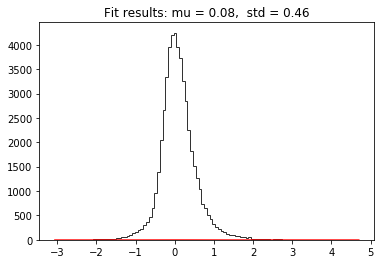

In [47]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
# Generate some data for this demonstration.
data = y_pred-y_true
# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=100, normed=False, alpha=0.8, histtype="step", color="k")

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=1)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

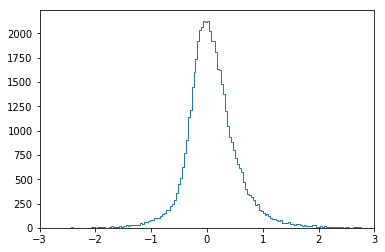

In [34]:
plt.hist(y_pred-y_true, bins=200, histtype="step")
plt.xlim(-3,3)
plt.plot()
plt.show()

In [53]:
curve_fit?

Fitted mean =  0.030298559874
Fitted standard deviation =  0.335324001884


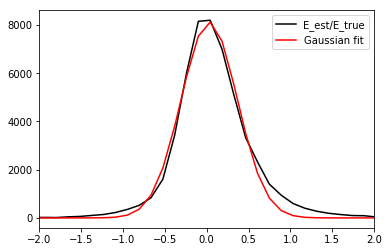

In [70]:
import numpy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define some test data which is close to Gaussian
data = y_pred-y_true

hist, bin_edges = numpy.histogram(data, density=False, bins=50)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

plt.plot(bin_centres, hist, label='E_est/E_true', color='k')
plt.plot(bin_centres, hist_fit, label='Gaussian fit',color='r')
plt.legend(loc="upper right")
plt.xlim(-2,2)
# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted mean = ', coeff[1])
print('Fitted standard deviation = ', coeff[2])

plt.show()

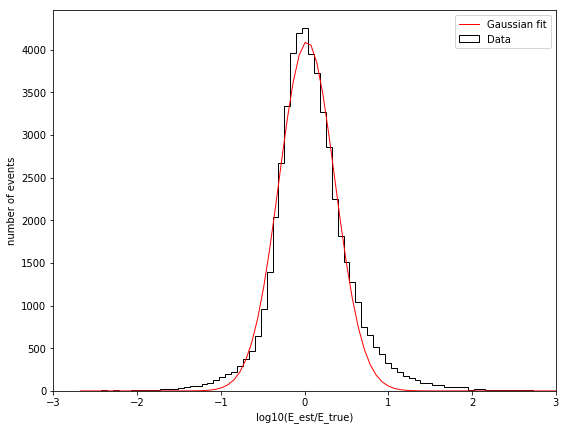

In [41]:
import pylab as py
import numpy as np
from scipy import optimize

# Generate a 
#y = np.random.standard_normal(10000)
py.figure(figsize=(9,7))
y = y_pred-y_true
data = py.hist(y, bins = 100, histtype="step", color="k", label="Data")

# Equation for Gaussian
def f(x, a, b, c):
    return a * py.exp(-(x - b)**2.0 / (2 * c**2))

# Generate data from bins as a set of points 
x = [0.5 * (data[1][i] + data[1][i+1]) for i in range(len(data[1])-1)]
y = data[0]

popt, pcov = optimize.curve_fit(f, x, y)
py.xlim(-3,3)
x_fit = py.linspace(x[0], x[-1], 100)
y_fit = f(x_fit, *popt)
py.plot(x_fit, y_fit, lw=1, color="r",label="Gaussian fit")
py.legend(loc="upper right")
py.xlabel("log10(E_est/E_true)")
py.ylabel("number of events")
py.show()

In [39]:
popt[-2:]

array([ 0.02917161,  0.33215625])

In [31]:
optimize.curve_fit?

In [32]:
popt

array([  4.09311943e+03,   2.91716124e-02,   3.32156252e-01])

In [33]:
pcov

array([[  2.77555594e+03,  -6.82895832e-09,  -1.50159930e-01],
       [ -6.82895832e-09,   2.43713392e-05,  -2.39439308e-13],
       [ -1.50159930e-01,  -2.39439308e-13,   2.43713390e-05]])

In [66]:
bins = np.linspace(np.min(y_true), np.max(y_true),10)
indices = np.digitize(y_true, bins)

y_true_vals_p34 = []
y_true_vals_m34 = []
y_pred_vals_p34 = []
y_pred_vals_m34 = []

y_true_vals_p45 = []
y_true_vals_m45 = []
y_pred_vals_p45 = []
y_pred_vals_m45 = []
y_true_median = []
y_pred_median = []

for i in range(1,len(bins)+1):
    indices_bin = np.where(indices==i)[0]
    sorted_bin_content = np.sort(y_true[np.where(indices==i)[0]])
    argsorted_bin_content = np.argsort(y_true[np.where(indices==i)[0]])
    median_index = int(np.floor(len(sorted_bin_content)/2))
    count_34 = int(np.floor((len(sorted_bin_content)/100.)*34))
    count_45 = int(np.floor((len(sorted_bin_content)/100.)*45))    
 
    y_true_vals_p34.append(y_true[indices_bin[argsorted_bin_content[median_index+count_34]]])
    y_true_vals_m34.append(y_true[indices_bin[argsorted_bin_content[median_index-count_34]]])
    y_true_vals_p45.append(y_true[indices_bin[argsorted_bin_content[median_index+count_45]]])
    y_true_vals_m45.append(y_true[indices_bin[argsorted_bin_content[median_index-count_45]]])

    y_pred_vals_p34.append(y_pred[indices_bin[argsorted_bin_content[median_index+count_34]]])
    y_pred_vals_m34.append(y_pred[indices_bin[argsorted_bin_content[median_index-count_34]]])
    y_pred_vals_p45.append(y_pred[indices_bin[argsorted_bin_content[median_index+count_45]]])
    y_pred_vals_m45.append(y_pred[indices_bin[argsorted_bin_content[median_index-count_45]]])
    y_true_median.append(y_true[indices_bin[argsorted_bin_content[median_index]]])
    y_pred_median.append(y_pred[indices_bin[argsorted_bin_content[median_index]]])

In [67]:
print(y_true_median[0], y_true_vals_m34[0], y_true_vals_p34[0])

(-0.39404884243512706, -1.2378115128473102, -0.33185832612773974)


In [68]:
print(y_pred_median[0], y_pred_vals_m34[0], y_pred_vals_p34[0])

(3.1135008, 2.9106567, 3.7015076)


(0.8, 8.5292121915689378)

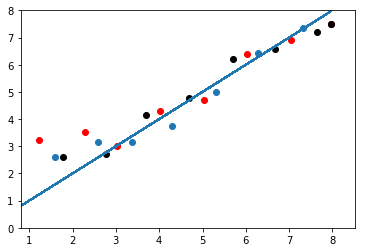

In [69]:
plt.scatter(y_true_median, y_pred_median)
plt.scatter(y_true_vals_m34, y_pred_vals_m34,c='r')
plt.scatter(y_true_vals_p34, y_pred_vals_p34,c='k')
plt.plot(y_true, y_true)
plt.ylim(0,8)
plt.xlim(0.8)

In [70]:
for i in range(len(bins)):
    print(y_true_vals_m34[i], y_true_median[i], y_true_vals_p34[i])

(-1.2378115128473102, -0.39404884243512706, -0.33185832612773974)
(0.24740119135811661, 0.54170651850539897, 0.69978397751572619)
(1.2328309963110347, 1.5844205622199947, 1.7732135882437396)
(2.2787970282296914, 2.5924354798411642, 2.7818092094745825)
(3.0224118734559209, 3.3679873323182274, 3.6993641648038031)
(4.0133471158695526, 4.2978370802021395, 4.6944709417074311)
(5.0233059712967076, 5.3162744548990171, 5.6942664048613016)
(6.0227293447174324, 6.2893280299559313, 6.6734476153631661)
(7.0462141282063273, 7.325376075598462, 7.6477310486863495)
(7.9678179223876731, 7.9678179223876731, 7.9678179223876731)


In [71]:
for i in range(len(bins)):
    print(y_pred_vals_m34[i], y_pred_median[i], y_pred_vals_p34[i])

(2.9106567, 3.1135008, 3.7015076)
(2.9723828, 2.4519985, 2.6818912)
(3.2126088, 2.5957894, 2.6060965)
(3.5142684, 3.1438234, 2.7138333)
(3.0223808, 3.1388962, 4.1504736)
(4.3139238, 3.7515776, 4.7604451)
(4.710546, 5.0063257, 6.2110853)
(6.3783979, 6.4313097, 6.5945616)
(6.9068933, 7.3561473, 7.2068219)
(7.4826608, 7.4826608, 7.4826608)


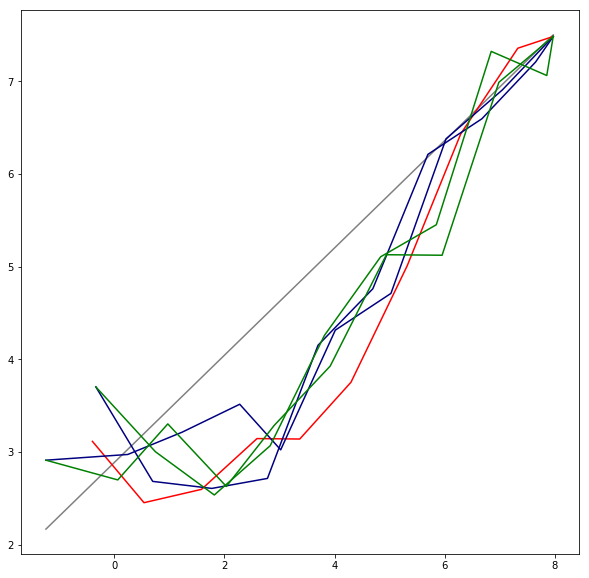

In [72]:
plt.figure(figsize=(10,10))
plt.plot([np.min(y_true),np.max(y_true)],[np.min(y_pred), np.max(y_pred)], lw=1.5, linestyle='-', color='grey')
plt.plot(y_true_median, y_pred_median, c='red')
plt.plot(y_true_vals_m34, y_pred_vals_m34, c='navy')
plt.plot(y_true_vals_p34, y_pred_vals_p34, c='navy')
plt.plot(y_true_vals_m45, y_pred_vals_m45, c='g')
plt.plot(y_true_vals_p45, y_pred_vals_p45, c='g')

In [18]:
from scipy.stats import bayes_mvs

In [ ]:
for i in 

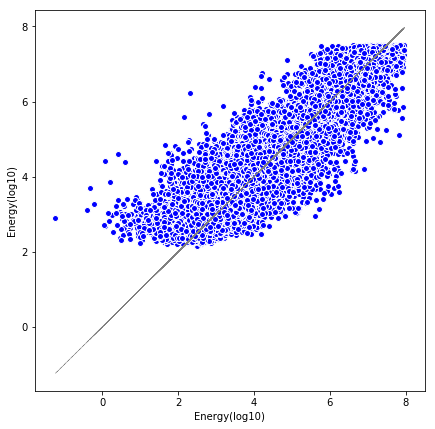

In [20]:
plt.figure(figsize=(7, 7))
plt.plot(y_true, y_true, color='grey', linestyle='-.', lw=0.5)
plt.scatter(y_true, y_pred, marker='o', color="blue", edgecolor='w')
plt.xlabel('Energy(log10)')
plt.ylabel('Energy(log10)')
plt.title('')
plt.show()

In [36]:
from tqdm import tqdm

In [14]:

metadata = None
metadata_gen  = metadata_generator(index_split_files, multi_files_paths, metadata_keylist)

for i in tqdm(range(predict_steps)):
    metadata_batch = next(metadata_gen)
    if metadata is None:
        metadata = metadata_batch
    else:
        metadata = pd.concat((metadata, metadata_batch))

100%|██████████| 810/810 [00:01<00:00, 519.93it/s]


In [21]:
numu_files, nue_files = get_multi_data_files('/data/km3net/Xy_multi_data_files/', merge=False)

In [24]:
metadata.columns

Index(['E', 'posx', 'posy', 'posz', 'dirx', 'diry', 'dirz', 'file_evt_index',
       'evt_index'],
      dtype='object')

In [25]:
metadata['E'].shape

(51818,)

In [18]:
y_true_numu = list()
numu_test_indices = list()
sum_len = 0
sum_test = 0
for i in range(100):
    length = len(np.load(numu_files[i])['y'])
    sum_len += length
    md = metadata[(metadata["file_evt_index"] == i) & (metadata['evt_index'] < length)]
    y_true_numu.append(md['E'].apply(lambda e: np.log10(e)))
    test_indices = np.load(index_split_files[i])['test']
    sum_test += np.sum(test_indices < length)
    numu_test_indices.append(np.where(test_indices < length)[0])

In [22]:
y_true_numu = list()
y_true_nue = list()

numu_test_indices = list()
nue_test_indices = list()
sum_len_numu = 0
sum_test_numu = 0


sum_test_nue = 0

for i in range(100):
    length = len(np.load(numu_files[i])['y'])
    sum_len_numu += length
    md_numu = metadata[(metadata["file_evt_index"] == i) & (metadata['evt_index'] < length)]
    md_nue = metadata[(metadata["file_evt_index"] == i) & (metadata['evt_index'] >= length)]
    
    y_true_numu.append(md_numu['E'].apply(lambda e: np.log10(e)))
    y_true_nue.append(md_nue['E'].apply(lambda e: np.log10(e)))
    
    test_indices = np.load(index_split_files[i])['test']
    sum_test_numu += np.sum(test_indices < length)
    sum_test_nue += np.sum(test_indices >= length)
    
    numu_test_indices.append(np.where(test_indices < length)[0])
    nue_test_indices.append(np.where(test_indices>= length)[0])

In [30]:
sum_len_numu

151479

In [32]:
sum_test_nue

22835

In [33]:
sum_test_numu

28983

In [34]:
sum_test_nue+sum_test_numu

51818

In [22]:
y_pred_numu = list()
numu_percent = list()
for i in tqdm(range(100)):
    pred_steps, _ = get_n_iterations(fnames_test[i:i+1], batch_size=64)
    f_data_gen = data_generator(fnames_test[i:i+1], batch_size=64, fdata=get_TZ_XY, ftarget=lambda y: y)
    y_file_pred = list()
    for p in range(pred_steps):    
        X_batch, _ = next(f_data_gen)
        Y_batch_pred = model.predict_on_batch(X_batch)
        y_batch_pred = Y_batch_pred.ravel()
        y_file_pred.append(y_batch_pred)
    
    y_file_pred = np.hstack(y_file_pred)
    numu_percent.append((float(numu_test_indices[i].shape[0]) / y_file_pred.shape[0])*100)
    y_file_pred = y_file_pred[numu_test_indices[i]]
    y_pred_numu.append(y_file_pred)
y_pred_numu = np.hstack(np.asarray(y_pred_numu))

100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


### try to separate numu and nue

In [17]:
from tqdm import tqdm

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize

In [23]:
y_pred_numu = list()
y_pred_nue = list()
numu_percent = list()
nue_percent = list()
for i in tqdm(range(100)):
    pred_steps, _ = get_n_iterations(fnames_test[i:i+1], batch_size=64)
    f_data_gen = data_generator(fnames_test[i:i+1], batch_size=64, fdata=get_TZ_XY, ftarget=lambda y: y)
    y_file_pred = list()
    for p in range(pred_steps):    
        X_batch, _ = next(f_data_gen)
        Y_batch_pred = model.predict_on_batch(X_batch)
        y_batch_pred = Y_batch_pred.ravel()
        y_file_pred.append(y_batch_pred)
    
    y_file_pred = np.hstack(y_file_pred)
    numu_percent.append((float(numu_test_indices[i].shape[0]) / y_file_pred.shape[0])*100)
    y_file_pred_numu = y_file_pred[numu_test_indices[i]]
    y_file_pred_nue = y_file_pred[nue_test_indices[i]]
    y_pred_numu.append(y_file_pred_numu)
    y_pred_nue.append(y_file_pred_nue)
    
y_pred_numu = np.hstack(np.asarray(y_pred_numu))
y_pred_nue = np.hstack(np.asarray(y_pred_nue))

100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


In [24]:
y_true_numu = np.hstack(y_true_numu)

In [25]:
y_true_nue = np.hstack(y_true_nue)
y_true_nue.shape

(22835,)

In [26]:
y_pred_numu.shape

(28983,)

In [27]:
y_pred_nue.shape

(22835,)

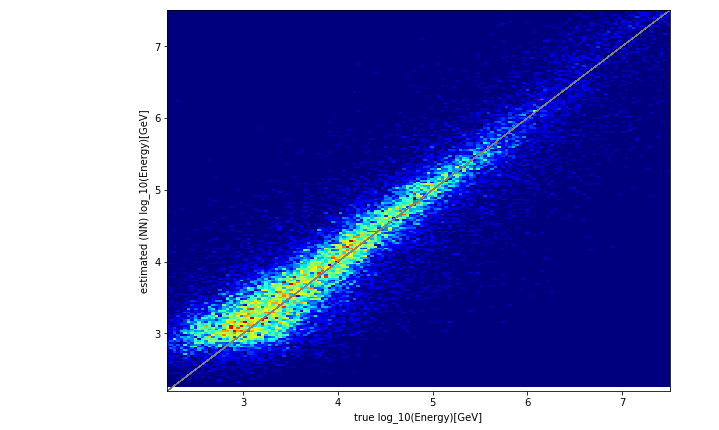

In [28]:
plt.figure(figsize=(9,7))
plt.plot(y_true_numu, y_true_numu, color='grey', linestyle='-.', lw=0.5)
# plt.plot(y_true, y_pred, color='k', linestyle='solid')
#plt.scatter(y_true, y_pred, marker='o', color="blue", edgecolor='w')
plt.hist2d(y_true_numu, y_pred_numu, bins=200, cmap='jet')
plt.xlabel('true log_10(Energy)[GeV]')
plt.ylabel('estimated (NN) log_10(Energy)[GeV]')
plt.xlim([2.2,7.5])
plt.ylim([2.2,7.5])
plt.title('')
plt.show()

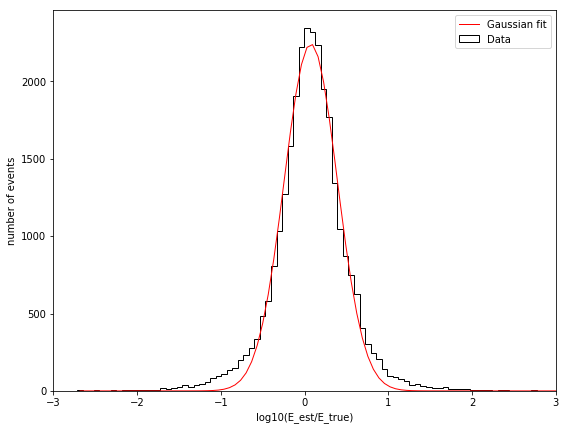

array([ 0.07436929,  0.31755791])

In [29]:
import pylab as py
import numpy as np
from scipy import optimize

# Generate a 
#y = np.random.standard_normal(10000)
py.figure(figsize=(9,7))
y = y_pred_numu-y_true_numu
data = py.hist(y, bins = 100, histtype="step", color="k", label="Data")

# Equation for Gaussian
def f(x, a, b, c):
    return a * py.exp(-(x - b)**2.0 / (2 * c**2))

# Generate data from bins as a set of points 
x = [0.5 * (data[1][i] + data[1][i+1]) for i in range(len(data[1])-1)]
y = data[0]

popt, pcov = optimize.curve_fit(f, x, y)
py.xlim(-3,3)
x_fit = py.linspace(x[0], x[-1], 100)
y_fit = f(x_fit, *popt)
py.plot(x_fit, y_fit, lw=1, color="r",label="Gaussian fit")
py.legend(loc="upper right")
py.xlabel("log10(E_est/E_true)")
py.ylabel("number of events")
py.show()
popt[-2:]

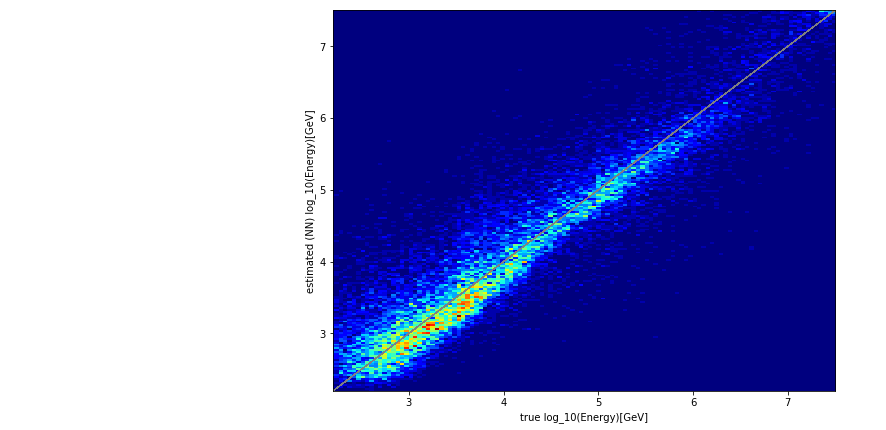

In [30]:
plt.figure(figsize=(9,7))
plt.plot(y_true_nue, y_true_nue, color='grey', linestyle='-.', lw=0.5)
# plt.plot(y_true, y_pred, color='k', linestyle='solid')
#plt.scatter(y_true, y_pred, marker='o', color="blue", edgecolor='w')
plt.hist2d(y_true_nue, y_pred_nue, bins=200, cmap='jet')
plt.xlabel('true log_10(Energy)[GeV]')
plt.ylabel('estimated (NN) log_10(Energy)[GeV]')
plt.xlim([2.2,7.5])
plt.ylim([2.2,7.5])
plt.title('')
plt.show()

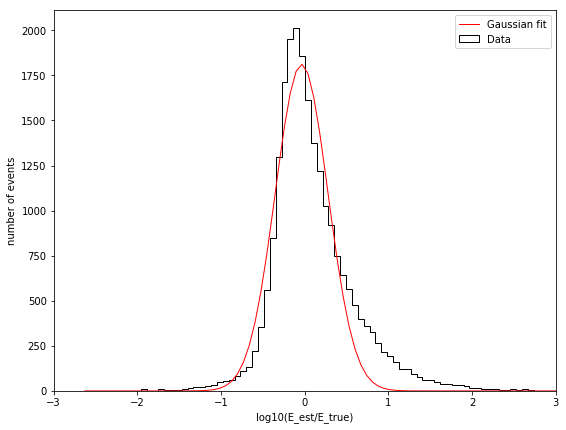

array([-0.03661703,  0.31502949])

In [59]:
import pylab as py
import numpy as np
from scipy import optimize

# Generate a 
#y = np.random.standard_normal(10000)
py.figure(figsize=(9,7))
y = y_pred_nue-y_true_nue
data = py.hist(y, bins = 100, histtype="step", color="k", label="Data")

# Equation for Gaussian
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2. * sigma**2))

# Generate data from bins as a set of points 
bins = data[1]
y = data[0]

new_x = [0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)]

popt, pcov = optimize.curve_fit(gauss, new_x, y, p0=[1,0,1])
py.xlim(-3,3)
x_fit = py.linspace(new_x[0], new_x[-1], 100)
y_fit = gauss(x_fit, *popt)
py.plot(x_fit, y_fit, lw=1, color="r",label="Gaussian fit")
py.legend(loc="upper right")
py.xlabel("log10(E_est/E_true)")
py.ylabel("number of events")
py.show()
popt[-2:]

In [56]:
optimize.curve_fit?

In [45]:
popt

array([  1.81160788e+03,  -3.66185020e-02,  -3.15027227e-01])

In [32]:
optimize.curve_fit?

In [49]:
y_pred_numu.shape

(28983,)

In [146]:
print("min_pred: {}, max_pred: {}, min_true: {}, max_true: {}".format(np.min(y_pred_numu), np.max(y_pred_numu), 
                                                                      np.min(y_true_numu), np.max(y_true_numu)))

min_pred: 2.25545859337, max_pred: 7.49871635437, min_true: 0.509858174864, max_true: 7.95159830864


In [147]:
mean_squared_error(y_true_numu, y_pred_numu)

0.19615983673228637

In [148]:
r2_score(y_true_numu, y_pred_numu)

0.84287056525388027

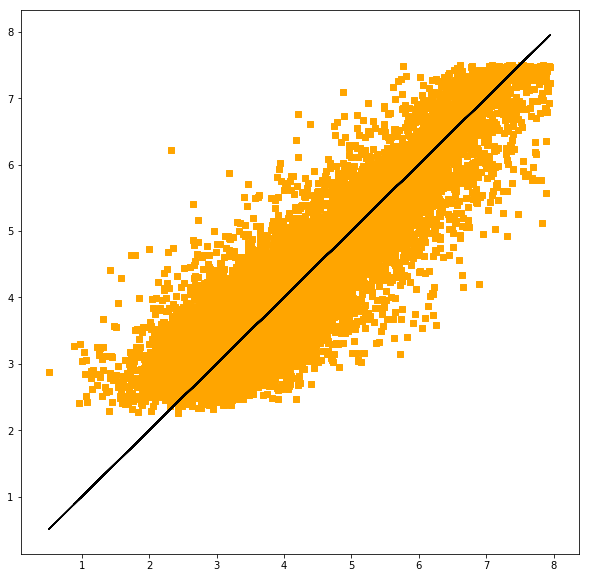

In [149]:
plt.figure(figsize=(10, 10))
plt.plot(y_true_numu, y_true_numu, color='k', linestyle='solid')
# plt.plot(y_true, y_pred, color='k', linestyle='solid')
plt.scatter(y_true_numu, y_pred_numu, marker='s', color='orange')
plt.show()

In [1]:
plt.figure(figsize=(8, 8))
plt.plot(10**y_true_numu, 10**y_true_numu, color='grey', linestyle='-.', lw=0.5)
# plt.plot(y_true, y_pred, color='k', linestyle='solid')
#plt.scatter(y_true, y_pred, marker='o', color="blue", edgecolor='w')
plt.hist2d(10**y_true_numu, 10**y_pred_numu, bins=200, cmap='jet')
plt.xlabel('"MC truth" Energy(log10)')
plt.ylabel('Predicted Energy(log10) ')
plt.title("Energy distribution")
plt.xlim([2.2,7.5])
plt.ylim([2.2,7.5])
plt.title('')
plt.show()

NameError: name 'plt' is not defined

### Plot history

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


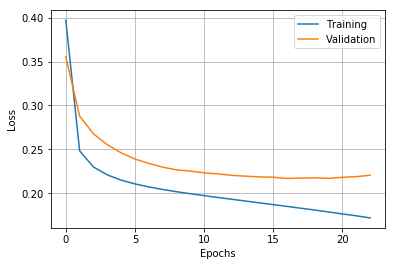

In [2]:
history = np.load("model/net_logE_shallow_relu_tanh_linear_net_history.pkl")
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history['loss'])
if 'val_loss' in history:
    plt.plot(history['val_loss'])
plt.grid()
plt.legend(['Training', 'Validation'])
plt.show()